1 Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

In [2]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [4]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
    predictions = np.zeros(X.shape[0])
    for i, x in enumerate(X):
        prediction = 0
        for alg in trees_list:
            prediction += eta * alg.predict([x])[0]
        predictions[i] = prediction
        
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y - z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z - y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [6]:
def residual(y, z):
    return - (z - y)

Реализуем функцию обучения градиентного бустинга.

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [8]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [9]:
%%time

# Число деревьев в ансамбле
n_trees = 50

# Максимальная глубина деревьев
max_depth = 5

# Шаг
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 1min 53s


In [10]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 251.77949969419439
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 4388.190931304676


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [11]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

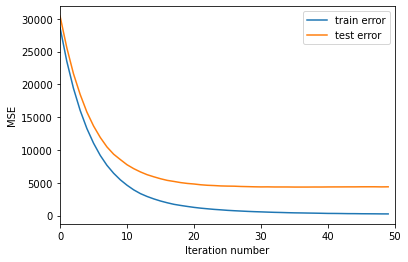

In [12]:
get_error_plot(n_trees, train_errors, test_errors)

---

Построим графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев.

In [25]:
import time
from tqdm import tqdm

train_errors = []
test_errors = []
eta = 0.1
max_depths = [1,3,5,30]
n_trees = [1,3,5,10,30]

for n_tree in tqdm(n_trees):
    for max_depth in max_depths:
        trees, train_error, test_error = gb_fit(n_tree, max_depth, X_train, X_test, y_train, y_test, eta)
        #print(evaluate_alg(X_train, X_test, y_train, y_test, trees, eta))
        train_errors.append(train_error)
        test_errors.append(test_error)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:09<00:00, 37.92s/it]


In [26]:
# функция распаковка вложенных списков
def list_merge(lstlst):
    all = []
    for lst in lstlst:
      all.extend(lst)
    return all

In [27]:
# распаковка вложенных списков ошибок
train_errors_merged = list_merge(train_errors)
test_errors_merged = list_merge(test_errors)

Построим график ошибки, когда идёт перебор количества деревьев в ансамбле. А максимальная глубина дерева - во вложенном цикле.

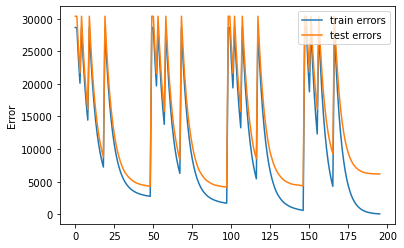

In [32]:
plt.plot(train_errors_merged, label='train errors')
plt.plot(test_errors_merged, label='test errors')
#plt.xlabel('N')
plt.ylabel('Error')
plt.legend(loc='upper right');

In [29]:
import time
from tqdm import tqdm

train_errors = []
test_errors = []
eta = 0.1
max_depths = [1,3,5,30]
n_trees = [1,3,5,10,30]

for max_depth in tqdm(max_depths):
    for n_tree in n_trees:
        trees, train_error, test_error = gb_fit(n_tree, max_depth, X_train, X_test, y_train, y_test, eta)
        #print(evaluate_alg(X_train, X_test, y_train, y_test, trees, eta))
        train_errors.append(train_error)
        test_errors.append(test_error)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:29<00:00, 52.36s/it]


In [30]:
# распаковка вложенных списков ошибок
train_errors_merged = list_merge(train_errors)
test_errors_merged = list_merge(test_errors)

Построим график ошибки, когда идёт перебор макимальной глубины дерева. А количество деревьев в ансамбле - во вложенном цикле.

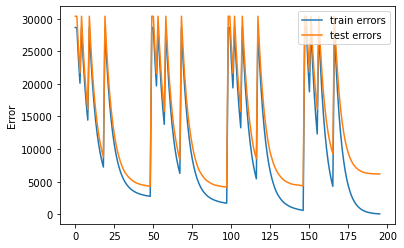

In [33]:
plt.plot(train_errors_merged, label='train errors')
plt.plot(test_errors_merged, label='test errors')
# plt.xlabel('N')
plt.ylabel('Error')
plt.legend(loc='upper right');

**Вывод:** при достижении определённого порога количества деревьев в ансамбле и глубины дерева, начинается переобучение модели.

2.* Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.